In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import requests
from scipy.integrate import odeint

In [2]:
# Fetches the data from the COVID19India website
class DataFetcher:
    def __init__(self, url="https://api.covid19india.org/data.json"):
        self.url = url
        self.json_data = None
        self.cases_time_series = None
        
    def fetch(self):
        r = requests.get(url=self.url)
        self.json_data = r.json()
        
        # Get the fields
        fields = list(self.json_data['cases_time_series'][0].keys())
        self.cases_time_series = {}
        
        for field in fields:
            if field == 'date':
                self.cases_time_series[field] = [x[field] for x in self.json_data['cases_time_series']]
            else:
                self.cases_time_series[field] = np.array([float(x[field]) for x in self.json_data['cases_time_series']])

<h2>A time dependent SIR model</h2>

$$  \frac{dS}{dt} = -\frac{\beta IS}{N} \tag1 $$
$$    \frac{dI}{dt} = \frac{\beta IS}{N} - \gamma I \tag2 $$
$$    \frac{dR}{dt} = \gamma I \tag3 $$


In [9]:
fetcher = DataFetcher()
fetcher.fetch()

In [10]:
# Create a function closure which stores the initial values 
def sir(initial_infected, initial_recovered):
    S_init = 1
    R_init = initial_recovered 
    I_init = initial_infected
    
    def model(xdata, beta, gamma):
        def f(vals, t, beta, gamma):
            S, I, R = vals
            S_dot = -beta * I * S
            I_dot = beta * I* S - gamma * I
            R_dot = gamma * I
            return [S_dot, I_dot, R_dot]

        results = odeint(f, [S_init, I_init, R_init], xdata, args=(beta,gamma))
        return results[:, 1] + results[:, 2]
    return model

Optimal params  [0.1555253  0.00037718]


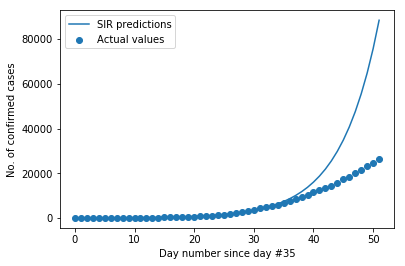

In [11]:
# Create a fit of values
TOTAL_LENGTH = len(fetcher.cases_time_series['totalconfirmed'])
SDAY, EDAY = 35, 70
POP = 1.2e9
BETA_LB = 0.0
xdata = np.array(range(EDAY - SDAY))
ydata = np.ones((EDAY - SDAY, 3))
ydata[:, 2] = (fetcher.cases_time_series['totaldeceased'][SDAY:EDAY] + fetcher.cases_time_series['totalrecovered'][SDAY:EDAY]) / POP
ydata[:, 1] = (fetcher.cases_time_series['totalconfirmed'][SDAY:EDAY] / POP)
ydata[:, 0] -= ydata[:, 1]

func = sir(ydata[:, 1][0], ydata[:, 2][0])
popt, pcov = curve_fit(func, xdata, ydata[:, 1], p0=(1e-7, 0.01))
print("Optimal params beta = {}, gamma = {}"format())

preds = func(range(TOTAL_LENGTH - SDAY), popt[0], popt[1]) * POP
actual = fetcher.cases_time_series['totalconfirmed'][SDAY:] 
plt.scatter(range(TOTAL_LENGTH - SDAY), actual, label="Actual values")
plt.plot(range(TOTAL_LENGTH - SDAY), preds, label="SIR predictions")
plt.xlabel("Day number since day #{}".format(SDAY))
plt.ylabel("No. of confirmed cases")
plt.legend()
plt.show()